In [1]:
!pip install gcm-filters
!pip install xrft==0.3.0

  Using cached gcm_filters-0.1.2-py3-none-any.whl (12 kB)


In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38169")
client

<Client: 'tcp://127.0.0.1:38169' processes=8 threads=64, memory=235.96 GiB>

In [3]:
client.restart()

<Client: 'tcp://127.0.0.1:33011' processes=0 threads=0, memory=0 B>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage import rotate
from xgcm.grid import Grid
import gcm_filters
import xrft
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36'])

In [6]:
# Functions to adapt croco outputs to xgcm
##########################################

def adjust_coords(ds):

    if 'lon_u' not in ds.coords:
        ##########################
        # for regular CROCO files:
        ds = ds.set_coords([c for c in ds.variables if 'lon' in c or 'lat' in c ])

    else:
        ##########################
        # for XIOS files:
        
        ds = ds.rename({'time_counter': 'time'})
        
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])

        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})

        # change axis names to xi,eta (instead of x,y)
        _dims = (d for d in ['x_u', 'x_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'xi' + d[1:]}) 

        _dims = (d for d in ['y_v', 'y_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'eta' + d[1:]}) 


        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 

        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('lat','lat').replace('lon','lon')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='deg', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )

    ##########################
    # For all types  
    if 'eta_psi' in ds.dims: ds = ds.rename({'eta_psi': 'eta_v'}) 
    if 'xi_psi' in ds.dims: ds = ds.rename({'xi_psi': 'xi_u'}) 
        
    '''    ##########################
    # Create xgcm grid
    coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
            'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
            's':{'center':'s_rho', 'outer':'s_w'}}

    ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords, periodic=[])
    '''

    return ds

###################################

    
def add_grd(ds,grd):
    
    ##########################
    for variable in grd.data_vars.keys():
        #print(variable)
        ds[variable] = grd[variable]
        
    ds['mask_rho'] = ds.mask_rho.where(ds.mask_rho>0,np.nan)
    
    if 'lon_psi' not in ds.coords: 
        #ds['lon_psi'] = grd['lon_psi']
        #ds['lat_psi'] = grd['lat_psi']
        ds = ds.assign_coords({'lon_psi':grd['lon_psi'], 'lat_psi':grd['lat_psi']})

    return ds
 
    ########
    
###################################


def dll_dist(dlon, dlat, lon, lat):
    """
    Converts lat/lon differentials into distances in meters
    
    parameters:
        dlon : xarray.DataArray longitude differentials 
        dlat : xarray.DataArray latitude differentials 
        lon : xarray.DataArray longitude values
        lat : xarray.DataArray latitude values
    returns:
        dx : xarray.DataArray distance inferred from dlon 
        dy : xarray.DataArray distance inferred from dlat 
    """
    
    distance_1deg_equator = 111000.0
    dx = dlon * xr.ufuncs.cos(xr.ufuncs.deg2rad(lat)) * distance_1deg_equator 
    dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
    return dx, dy

###################################

def add_vertical_coord(ds):
    
    if ds.VertCoordType=='NEW':
        ds['Vtransform'] = 2
    else:
        ds['Vtransform'] = 1

    #####################
    
    ds['sc_r'] = xr.DataArray(ds.sc_r,  dims=["s_rho"])
    ds['sc_w'] = xr.DataArray(ds.sc_w,  dims=["s_w"])
    ds['Cs_r'] = xr.DataArray(ds.Cs_r,  dims=["s_rho"])
    ds['Cs_w'] = xr.DataArray(ds.Cs_w,  dims=["s_w"])

    #####################
    # Including vertical coordinates

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.sc_r - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.sc_r + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho; del Zo_rho

    ds.coords['z_rho'] = z_rho  * ds.mask_rho

    if ds.Vtransform == 1:
        Zo_w = ds.hc * (ds.sc_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_rho + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_w = (ds.hc * ds.sc_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w; del Zo_w

    ds.coords['z_w'] = z_w  * ds.mask_rho
    
    return ds


###################################
    
def _compute_metrics_curvilinear(ds):
    """
    Create a xgcm grid and set it in the dataset as a attribute

    Parameters:
        ds : xarray dataset
    returns:
        ds : xarray dataset with the xgcm  grid
        grid : xgcm grid
    """

    # curvilinear grid
    # Create xgcm grid without any metrics
    coords={'x':{'center':'xi_rho',  'inner':'xi_u'}, 
            'y':{'center':'eta_rho', 'inner':'eta_v'}, 
            'z':{'center':'s_rho',   'outer':'s_w'}}

    grid = Grid(ds, 
              coords=coords,
              boundary='extend')

    # Computes lon/lat at u,v and psi points, and assign to the dataset as coordinates
    ds['lon_u'] = grid.interp(ds.lon_rho,'x')
    ds['lat_u'] = grid.interp(ds.lat_rho,'x')
    ds['lon_v'] = grid.interp(ds.lon_rho,'y')
    ds['lat_v'] = grid.interp(ds.lat_rho,'y')
    ds['lon_psi'] = grid.interp(ds.lon_v,'x')
    ds['lat_psi'] = grid.interp(ds.lat_u,'y')
    _coords = ['lon_u','lat_u','lon_v','lat_v','lon_psi','lat_psi']
    ds = ds.set_coords(_coords)
    
    # Computes lon/lat at u,v and psi points, and assign to the dataset as coordinates
    ds['z_u'] = grid.interp(ds.z_rho,'x')
    ds['z_v'] = grid.interp(ds.z_rho,'y')
    _coords = ['z_u','z_v']
    ds = ds.set_coords(_coords)
    

    # add horizontal distance metrics for rho, u, v and psi point
    if 'pm' in ds and 'pn' in ds:
        ds['dx_rho'] = 1/ds['pm']
        ds['dy_rho'] = 1/ds['pn']
    else: # backward compatibility, hack
        dlon = grid.interp(grid.diff(ds.lon_rho,'x'),'x')
        dlat =  grid.interp(grid.diff(ds.lat_rho,'y'),'y')
        ds['dx_rho'], ds['dy_rho'] = dll_dist(dlon, dlat, ds.lon_rho, ds.lat_rho)
    
    dlon = grid.interp(grid.diff(ds.lon_u,'x'),'x')
    dlat = grid.interp(grid.diff(ds.lat_u,'y'),'y')
    ds['dx_u'], ds['dy_u'] = dll_dist(dlon, dlat, ds.lon_u, ds.lat_u)
    dlon = grid.interp(grid.diff(ds.lon_v,'x'),'x')
    dlat = grid.interp(grid.diff(ds.lat_v,'y'),'y')
    ds['dx_v'], ds['dy_v'] = dll_dist(dlon, dlat, ds.lon_v, ds.lat_v)
    dlon = grid.interp(grid.diff(ds.lon_psi,'x'),'x')
    dlat = grid.interp(grid.diff(ds.lat_psi,'y'),'y')
    ds['dx_psi'], ds['dy_psi'] = dll_dist(dlon, dlat, ds.lon_psi, ds.lat_psi)

    
    ds['mask_psi'] = grid.interp(grid.interp(ds.mask_rho, 'y'),  'x') 
    
    # add vertical metrics for u, v, rho and psi points
    ds['dz_rho'] = grid.diff(ds.z_w,'z')
    ds['dz_w']   = grid.diff(ds.z_rho,'z')
    ds['dz_u']   = grid.interp(ds.dz_rho,'x')
    ds['dz_v']   = grid.interp(ds.dz_rho,'y')
    ds['dz_psi'] = grid.interp(ds.dz_v,'x')

    # add areas metrics for rho,u,v and psi points
    ds['rArho'] = ds.dx_psi * ds.dy_psi
    ds['rAu']   = ds.dx_v   * ds.dy_v
    ds['rAv']   = ds.dx_u   * ds.dy_u
    ds['rApsi'] = ds.dx_rho * ds.dy_rho

    metrics = {
           ('x',): ['dx_rho', 'dx_u', 'dx_v', 'dx_psi'], # X distances
           ('y',): ['dy_rho', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
           ('z',): ['dz_rho', 'dz_u', 'dz_v', 'dz_psi', 'dz_w'], # Z distances
           ('x', 'y'): ['rArho', 'rAu', 'rAv', 'rApsi'] # Areas
          }

    ds.attrs['xgcm-Grid'] = Grid(ds, 
              coords=coords,
              metrics = metrics,
              periodic=False,
              boundary='extend')

    return ds

In [7]:
gigatl01w = _compute_metrics_curvilinear(add_vertical_coord(adjust_coords(cat.GIGATL(region='1', 
                                                                        datatype='int', season='fma').to_dask()
                         ))).chunk({'eta_rho':200,'xi_rho':200,'eta_v':200,'xi_u':200})
gigatl01s = _compute_metrics_curvilinear(add_vertical_coord(adjust_coords(cat.GIGATL(region='1', 
                                                                        datatype='int', season='aso').to_dask()
                         ))).chunk({'eta_rho':200,'xi_rho':200,'eta_v':200,'xi_u':200})

gigatl01w

<xarray.Dataset>
Dimensions:     (eta_rho: 1541, eta_v: 1540, s_rho: 100, s_w: 101, time: 89, xi_rho: 1576, xi_u: 1575)
Coordinates:
    lat_rho     (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    z_rho       (time, eta_rho, xi_rho, s_rho) float64 dask.array<chunksize=(1, 200, 200, 100), meta=np.ndarray>
    z_w         (time, eta_rho, xi_rho, s_w) float64 dask.array<chunksize=(1, 200, 200, 101), meta=np.ndarray>
    lon_u       (eta_rho, xi_u) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lat_u       (eta_rho, xi_u) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon_v       (eta_v, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lat_v       (eta_v, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon_psi     (eta_v, xi_u) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lat_psi     (eta_v, xi_u) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    z_u         (time, eta_rho, xi_u, s_rho) float64 dask.array<chunksize=(1, 200, 200, 100), meta=np.ndarray>
    z_v         (time, eta_v, xi_rho, s_rho) float64 dask.array<chunksize=(1, 200, 200, 100), meta=np.ndarray>
Dimensions without coordinates: eta_rho, eta_v, s_rho, s_w, time, xi_rho, xi_u
Data variables: (12/36)
    angle       (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    f           (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    h           (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    mask_rho    (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    ocean_time  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    pm          (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    ...          ...
    dz_v        (time, eta_v, xi_rho, s_rho) float64 dask.array<chunksize=(1, 200, 200, 100), meta=np.ndarray>
    dz_psi      (time, eta_v, xi_u, s_rho) float64 dask.array<chunksize=(1, 200, 200, 100), meta=np.ndarray>
    rArho       (eta_v, xi_u) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    rAu         (eta_v, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    rAv         (eta_rho, xi_u) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    rApsi       (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
Attributes: (12/71)
    Akt_bak:         [0.0, 0.0]
    Akt_bak_expl:    background vertical mixing coefficient for tracers
    Akt_bak_units:   meter2 second-1
    Akv_bak:         0.0
    Akv_bak_expl:    background vertical mixing coefficient for momentum
    Akv_bak_units:   meter2 second-1
    ...              ...
    tnu4_expl:       biharmonic mixing coefficient for tracers
    type:            ROMS restart file
    units:           meter4 second-1
    v_sponge:        0.0
    x_sponge:        0.0
    xgcm-Grid:       <xgcm.Grid>\nx Axis (not periodic, boundary='extend'):\n...

In [8]:
grid = gigatl01w.attrs['xgcm-Grid']

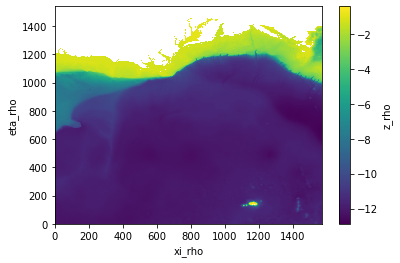

In [9]:
gigatl01w.z_rho.isel(s_rho=-4).where(gigatl01w.z_rho.isel(s_rho=-4)<0.).isel(time=0).plot()

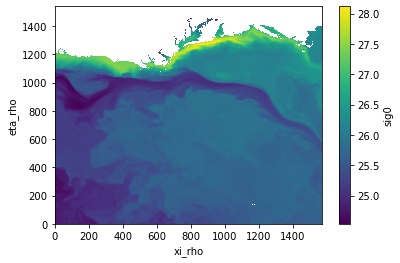

In [9]:
w_path = f'{SCRATCH}/region01/GIGATL/'+f'sigma0_fma_00.zarr' 
sig0win = xr.open_zarr(gcs.get_mapper(w_path)).sig0.where(gigatl01w.mask_rho!=0.)
sig0win.isel(s_rho=-1).plot()

In [9]:
grav = 9.81
for i in range(len(gigatl01w.time)):
    w_path = f'{SCRATCH}/region01/GIGATL/'+f'sigma0_fma_%02d.zarr' % i
    if i == 0:
        sig0win = xr.open_zarr(gcs.get_mapper(w_path)).sig0.where(gigatl01w.mask_rho!=0.)
    else:
        sig0win = xr.concat([sig0win,
                             xr.open_zarr(gcs.get_mapper(w_path)).sig0.where(gigatl01w.mask_rho!=0.)
                            ], 'time')
        
sig0win.coords['time'] = gigatl01w.time

b_win = -sig0win.where(gigatl01w.mask_rho!=0.).chunk({'s_rho':-1}) * grav / 1e3
b_win.coords['time'] = gigatl01w.time
b_win

<xarray.DataArray 'sig0' (time: 89, s_rho: 100, eta_rho: 1541, xi_rho: 1576)>
dask.array<truediv, shape=(89, 100, 1541, 1576), dtype=float64, chunksize=(1, 100, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    lat_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87 88
Dimensions without coordinates: s_rho, eta_rho, xi_rho

In [10]:
grav = 9.81
for i in range(len(gigatl01s.time)):
    s_path = f'{SCRATCH}/region01/GIGATL/'+f'sigma0_aso_%02d.zarr' % i
    if i == 0:
        sig0sum = xr.open_zarr(gcs.get_mapper(s_path)).sig0.where(gigatl01s.mask_rho!=0.)
    else:
        sig0sum = xr.concat([sig0sum,
                             xr.open_zarr(gcs.get_mapper(s_path)).sig0.where(gigatl01s.mask_rho!=0.)
                            ], 'time')
        
sig0sum.coords['time'] = gigatl01s.time

b_sum = -sig0sum.where(gigatl01s.mask_rho!=0.).chunk({'s_rho':-1}) * grav / 1e3
b_sum.coords['time'] = gigatl01s.time
b_sum

<xarray.DataArray 'sig0' (time: 92, s_rho: 100, eta_rho: 1541, xi_rho: 1576)>
dask.array<truediv, shape=(92, 100, 1541, 1576), dtype=float64, chunksize=(1, 100, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    lat_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 82 83 84 85 86 87 88 89 90 91
Dimensions without coordinates: s_rho, eta_rho, xi_rho

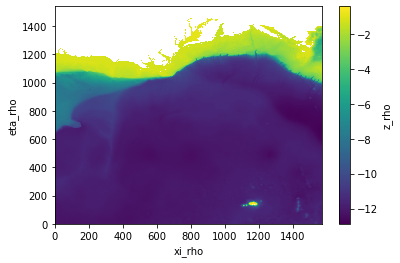

In [19]:
gigatl01w.z_rho.where(gigatl01w.z_rho<0.).isel(time=0,s_rho=-4).plot()

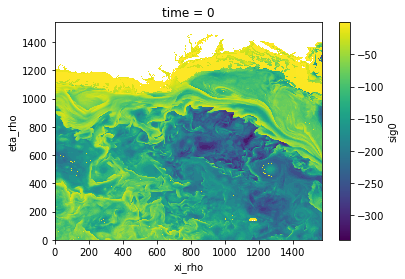

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88


In [21]:
s10 = 3    # grid index of ~10m depth
MLDw_s = xr.ones_like(sig0win.isel(s_rho=-1)).load()

for i in range(len(gigatl01w.time)):
    nMLDw = np.abs((sig0win.isel(time=i,s_rho=slice(None,-s10)).fillna(0.)
                    - sig0win.isel(time=i,s_rho=-s10-1).fillna(0.)
                   ) - .03).reset_coords(drop=True).argmin(dim='s_rho',skipna=True).compute()  # indexing needs loading
    MLDw_s[i] = gigatl01w.z_rho.where(gigatl01w.z_rho<0.).isel(time=i)[{'s_rho':nMLDw}].chunk({'eta_rho':200,'xi_rho':200})
    if i == 0:
        MLDw_s.isel(time=0).plot()
        plt.show()
    print(i)


In [22]:
tmp_path = f'{SCRATCH}/region01/GIGATL/'+f'MLD_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
MLDw_s.reset_coords(drop=True).chunk({'time':10}).to_dataset(name='MLD').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region01/GIGATL/MLD_fma.zarr


0
1
2
3
4
5
6
7
8
9


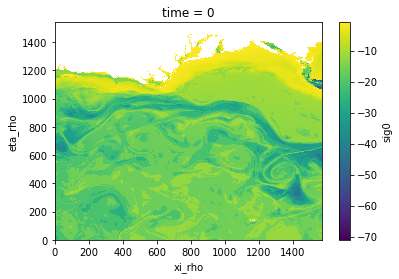

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91


In [23]:
s10 = 3
MLDs_s = xr.ones_like(sig0sum.isel(s_rho=-1)).load()

for i in range(len(gigatl01s.time)):
    nMLDs = np.abs((sig0sum.isel(time=i,s_rho=slice(None,-s10)).fillna(0.)
                    - sig0sum.isel(time=i,s_rho=-s10-1).fillna(0.)
                   ) - .03).reset_coords(drop=True).argmin(dim='s_rho').compute()  # indexing needs loading
    MLDs_s[i] = gigatl01s.z_rho.where(gigatl01s.z_rho<0.).isel(time=i)[{'s_rho':nMLDs}].chunk({'eta_rho':200,'xi_rho':200})
    if i == 10:
        MLDs_s.isel(time=0).plot()
        plt.show()
    print(i)

In [24]:
tmp_path = f'{SCRATCH}/region01/GIGATL/'+f'MLD_aso.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
MLDs_s.reset_coords(drop=True).chunk({'time':10}).to_dataset(name='MLD').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region01/GIGATL/MLD_aso.zarr


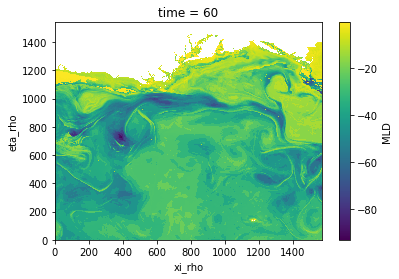

In [11]:
MLDw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/GIGATL/MLD_fma.zarr")).MLD
MLDs = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/GIGATL/MLD_aso.zarr")).MLD
MLDs.isel(time=60).plot()

# Vertical remapping

In [12]:
zs = np.concatenate((np.linspace(-1,-35.97241992,10, endpoint=False), 
                     (1+np.tanh(np.linspace(-2,0,40)))*-1e3))
zs

array([   -1.        ,    -4.49724199,    -7.99448398,   -11.49172598,
         -14.98896797,   -18.48620996,   -21.98345195,   -25.48069394,
         -28.97793594,   -32.47517793,   -35.97241992,   -39.78046085,
         -43.98259356,   -48.61760123,   -53.72764218,   -59.35844536,
         -65.55949394,   -72.38418994,   -79.88999134,   -88.13851145,
         -97.19556852,  -107.13117135,  -118.01942498,  -129.93833826,
        -142.96951336,  -157.19769577,  -172.71016215,  -189.5959236 ,
        -207.94472229,  -227.84580243,  -249.38644026,  -272.65022457,
        -297.71508832,  -324.65110349,  -353.51806624,  -384.36291638,
        -417.21705465,  -452.09364143,  -488.98498044,  -527.8601091 ,
        -568.66273012,  -611.30962635,  -655.68969811,  -701.66375002,
        -749.06512919,  -797.70128075,  -847.35624019,  -897.79402802,
        -948.76285616, -1000.        ])

In [13]:
zp1s = np.concatenate((np.array([0.]),.5*(zs[1:] + zs[:-1])))
from scipy.interpolate import interp1d
f = interp1d(np.arange(len(np.diff(zp1s))), np.abs(np.diff(zp1s)), fill_value='extrapolate')
dzp1s = f(np.arange(len(np.diff(zp1s))+1))
dzp1s

array([ 2.748621  ,  3.49724199,  3.49724199,  3.49724199,  3.49724199,
        3.49724199,  3.49724199,  3.49724199,  3.49724199,  3.49724199,
        3.65264146,  4.00508682,  4.41857019,  4.87252431,  5.37042207,
        5.91592588,  6.51287229,  7.1652487 ,  7.87716075,  8.65278859,
        9.49632995, 10.41192823, 11.40358345, 12.47504419, 13.62967876,
       14.8703244 , 16.19911391, 17.61728007, 19.12493942, 20.72085899,
       22.40221107, 24.16432403, 26.00043946, 27.90148896, 29.85590644,
       31.84949421, 33.86536253, 35.8839629 , 37.88323384, 39.83887484,
       41.72475863, 43.51348399, 45.17706184, 46.68771554, 48.01876536,
       49.1455555 , 50.04637364, 50.70330799, 51.10298599, 51.50266399])

In [14]:
ww = grid.transform(gigatl01w.w.chunk({'s_rho':-1}).astype(np.float64), 'z', zs, target_data=gigatl01w.z_rho)
ww

<xarray.DataArray 'w' (time: 89, eta_rho: 1541, xi_rho: 1576, z_rho: 50)>
dask.array<transpose, shape=(89, 1541, 1576, 50), dtype=float64, chunksize=(1, 200, 200, 50), chunktype=numpy.ndarray>
Coordinates:
    lat_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
  * z_rho    (z_rho) float64 -1.0 -4.497 -7.994 -11.49 ... -897.8 -948.8 -1e+03
Dimensions without coordinates: time, eta_rho, xi_rho

In [15]:
Z_rho = gigatl01w.z_rho
Z_rho.coords['time'] = gigatl01w.time

bw = grid.transform(b_win.astype(np.float64), 'z', zs, target_data=Z_rho)
bw

<xarray.DataArray 'sig0' (time: 89, eta_rho: 1541, xi_rho: 1576, z_rho: 50)>
dask.array<transpose, shape=(89, 1541, 1576, 50), dtype=float64, chunksize=(1, 200, 200, 50), chunktype=numpy.ndarray>
Coordinates:
    lat_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87 88
  * z_rho    (z_rho) float64 -1.0 -4.497 -7.994 -11.49 ... -897.8 -948.8 -1e+03
Dimensions without coordinates: eta_rho, xi_rho

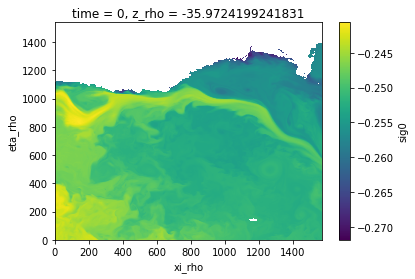

In [16]:
bw.isel(time=0,z_rho=10).plot()

# Spatial filtering using the [`gcm-filters`](https://gcm-filters.readthedocs.io/en/latest/) package

In [17]:
sw = grid.transform(gigatl01w.salt.where(gigatl01w.mask_rho==1).isel(time=0).chunk({'s_rho':-1}), 
                    'z', zs, 
                    target_data=gigatl01w.z_rho.isel(time=0))
mask = ~np.ma.masked_invalid(sw).mask
mask

array([[[False,  True,  True, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  True,  True],
        ...,
        [False,  True,  True, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False]],

       [[False,  True,  True, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  True,  True],
        ...,
        [False,  True,  True, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False]],

       [[False,  True,  True, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  True,  True],
        ...,
        [False,  True,  True, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  Tr

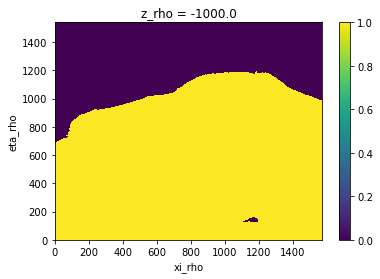

In [18]:
pad = 1
xrmask = xr.DataArray(mask.astype(np.float64), dims=sw.dims,
                      coords=sw.coords
                     )
mask[:2,:] = 0.
mask[-2:,:] = 0.
mask[:,:2] = 0.
mask[:,-2:] = 0.
wet_mask = xr.DataArray(mask.astype(np.float64), dims=sw.dims,
                        coords=sw.coords
                       )

wet_mask.isel(z_rho=-1).plot()

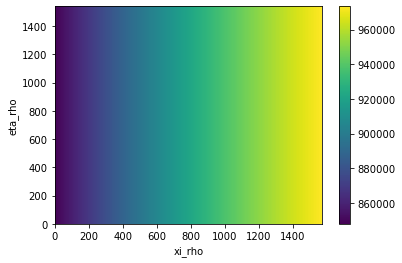

In [11]:
area = (gigatl01w.pm**-1 * gigatl01w.pn**-1)

area.plot()

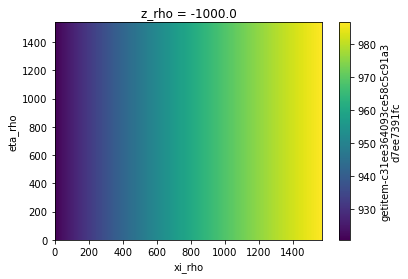

In [20]:
dxw = xr.DataArray(grid.interp(gigatl01w.pm**-1,
                               'x').isel(eta_rho=slice(None,-1)).data,  # x-spacing centered at western cell edge
                   dims=['eta_rho','xi_rho'], 
                   coords=wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1),
                                        z_rho=-1).coords
                  )
dxw[:,:] = np.nan_to_num(dxw[:,:],nan=1)

dyw = xr.DataArray(grid.interp(gigatl01w.pn**-1,
                               'x').isel(eta_rho=slice(None,-1)).data,  # y-spacing centered at western cell edge
                   dims=['eta_rho','xi_rho'],
                   coords=wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1),
                                        z_rho=-1).coords
                  )
dyw[:,:] = np.nan_to_num(dyw[:,:],nan=1)

dxs = xr.DataArray(grid.interp(gigatl01w.pm**-1,
                               'y').isel(xi_rho=slice(None,-1)).data,  # x-spacing centered at southern cell edge
                   dims=['eta_rho','xi_rho'],
                   coords=wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1),
                                        z_rho=-1).coords
                  ) 
dxs[:,:] = np.nan_to_num(dxs[:,:],nan=1)

dys = xr.DataArray(grid.interp(gigatl01w.pn**-1,
                               'y').isel(xi_rho=slice(None,-1)).data,  # y-spacing centered at southern cell edge
                   dims=['eta_rho','xi_rho'],
                   coords=wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1),
                                        z_rho=-1).coords
                  ) 
dys[:,:] = np.nan_to_num(dys[:,:],nan=1)
dxw.plot()

In [21]:
dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min()
            )
dx_min = dx_min.values
dx_min

array(920.77026, dtype=float32)

In [22]:
kappa_w = xr.ones_like(wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1),z_rho=-1))

kappa_s = xr.ones_like(wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1),z_rho=-1)) 

In [22]:
filter_scale = 50000   # 50 km

filter_50km = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    n_steps=50,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.isel(eta_rho=slice(None,-1),
                                  xi_rho=slice(None,-1)).chunk({'eta_rho':-1,'xi_rho':-1}), 
        'dxw': dxw.chunk({'eta_rho':-1,'xi_rho':-1}), 'dyw': dyw.chunk({'eta_rho':-1,'xi_rho':-1}), 
        'dxs': dxs.chunk({'eta_rho':-1,'xi_rho':-1}), 'dys': dys.chunk({'eta_rho':-1,'xi_rho':-1}), 
        'area': area.isel(eta_rho=slice(None,-1),
                          xi_rho=slice(None,-1)).chunk({'eta_rho':-1,'xi_rho':-1}), 
        'kappa_w': kappa_w.chunk({'eta_rho':-1,'xi_rho':-1}), 
        'kappa_s': kappa_s.chunk({'eta_rho':-1,'xi_rho':-1})
    }
)
filter_50km

<string>:11: UserWarning: You have set n_steps below the default. Results might not be accurate.


Filter(filter_scale=50000, dx_min=array(920.77026, dtype=float32), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=50, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

In [23]:
filter_30km = gcm_filters.Filter(
    filter_scale=3e4,   # 30 km
    dx_min=dx_min,
#     n_steps=50,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.isel(eta_rho=slice(None,-1),
                                  xi_rho=slice(None,-1)).chunk({'eta_rho':-1,'xi_rho':-1}), 
        'dxw': dxw.chunk({'eta_rho':-1,'xi_rho':-1}), 'dyw': dyw.chunk({'eta_rho':-1,'xi_rho':-1}), 
        'dxs': dxs.chunk({'eta_rho':-1,'xi_rho':-1}), 'dys': dys.chunk({'eta_rho':-1,'xi_rho':-1}), 
        'area': area.isel(eta_rho=slice(None,-1),
                          xi_rho=slice(None,-1)).chunk({'eta_rho':-1,'xi_rho':-1}), 
        'kappa_w': kappa_w.chunk({'eta_rho':-1,'xi_rho':-1}), 
        'kappa_s': kappa_s.chunk({'eta_rho':-1,'xi_rho':-1})
    }
)

In [24]:
ww_filtered_to_30km = filter_30km.apply(ww.isel(eta_rho=slice(None,-1),
                                                xi_rho=slice(None,-1)
                                               ).chunk({'eta_rho':-1,'xi_rho':-1}), 
                                        dims=['eta_rho', 'xi_rho']
                                       ).chunk({'eta_rho':200,'xi_rho':200})


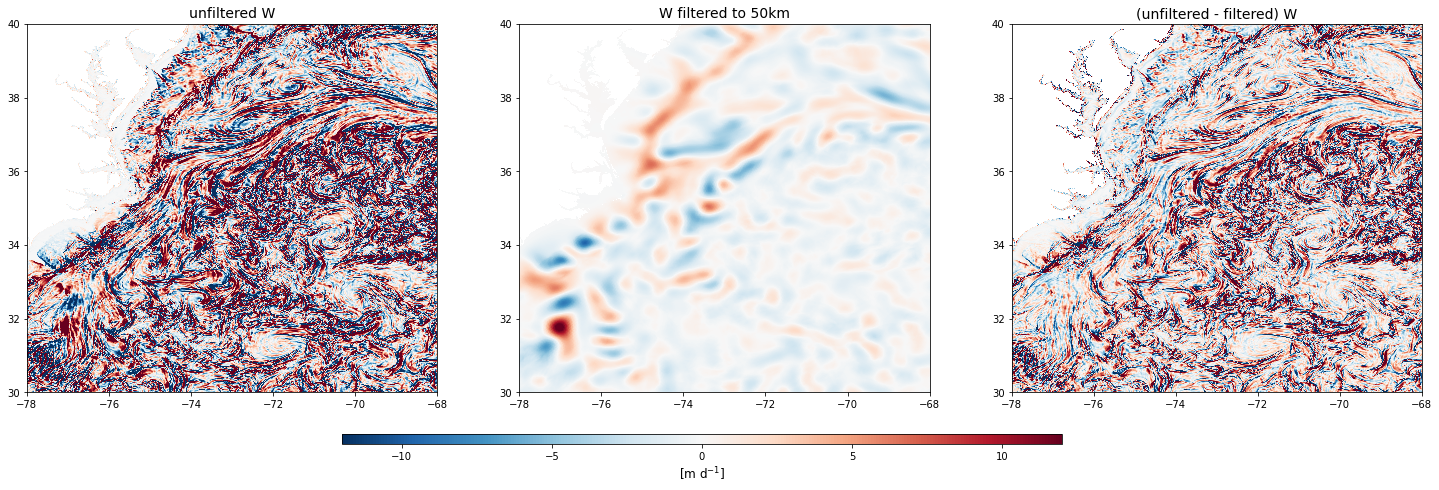

In [25]:
vmin = -12
vmax = 12


fig,axs = plt.subplots(1,3,figsize=(25,8))

im = axs[0].pcolormesh(gigatl01w.lon_rho.isel(eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad)),
                       gigatl01w.lat_rho.isel(eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad)),
                       (ww*86400).isel(time=0,eta_rho=slice(pad+1,-2-pad),
                                       xi_rho=slice(pad+1,-2-pad),z_rho=5),
    vmin=vmin, vmax=vmax, 
    cmap='RdBu_r', shading='auto', rasterized=True
)
axs[0].set_title('unfiltered W', fontsize=14)

axs[1].pcolormesh(gigatl01w.lon_rho.isel(eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad)),
                  gigatl01w.lat_rho.isel(eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad)),
                  (ww_filtered_to_50km*86400).isel(time=0,eta_rho=slice(pad+1,-pad-1),
                                                   xi_rho=slice(pad+1,-pad-1),z_rho=5),
    vmin=vmin, vmax=vmax, 
    cmap='RdBu_r', shading='auto', rasterized=True
)
axs[1].set_title('W filtered to 50km', fontsize=14)

axs[2].pcolormesh(gigatl01w.lon_rho.isel(eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad)),
                  gigatl01w.lat_rho.isel(eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad)),
                  ((ww.isel(time=0,eta_rho=slice(pad+1,-2-pad),
                            xi_rho=slice(pad+1,-2-pad),z_rho=3)
                    - ww_filtered_to_50km.isel(time=0,eta_rho=slice(pad+1,-pad-1),xi_rho=slice(pad+1,-pad-1),z_rho=5)
                   )*86400).isel(eta_rho=slice(None,None),xi_rho=slice(None,None)),
    vmin=vmin, vmax=vmax,
    cmap='RdBu_r', shading='auto', rasterized=True
)
axs[2].set_title('(unfiltered - filtered) W', fontsize=14);

axs[0].set_xlim([-78,-68])
axs[0].set_ylim([30,40])
axs[1].set_xlim([-78,-68])
axs[1].set_ylim([30,40])
axs[2].set_xlim([-78,-68])
axs[2].set_ylim([30,40])

fig.subplots_adjust(bottom=0.24, hspace=.25)
cbaxes = fig.add_axes([0.3, 0.15, 0.4, 0.018]) 
cbar = fig.colorbar(im, orientation='horizontal', cax=cbaxes,
#                     ticks=[-2.8,-2.1,-1.4,-.7,0.,.7,1.4,2.1,2.8]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r'[m d$^{-1}$]', fontsize=12)

plt.savefig('/home/jovyan/Figures/GIGA01_wp_Feb-01.pdf')

In [25]:
bw_filtered_to_30km = filter_30km.apply(bw.isel(eta_rho=slice(None,-1),
                                                xi_rho=slice(None,-1)
                                               ).chunk({'eta_rho':-1,'xi_rho':-1}), 
                                        dims=['eta_rho', 'xi_rho']
                                       ).chunk({'eta_rho':200,'xi_rho':200})


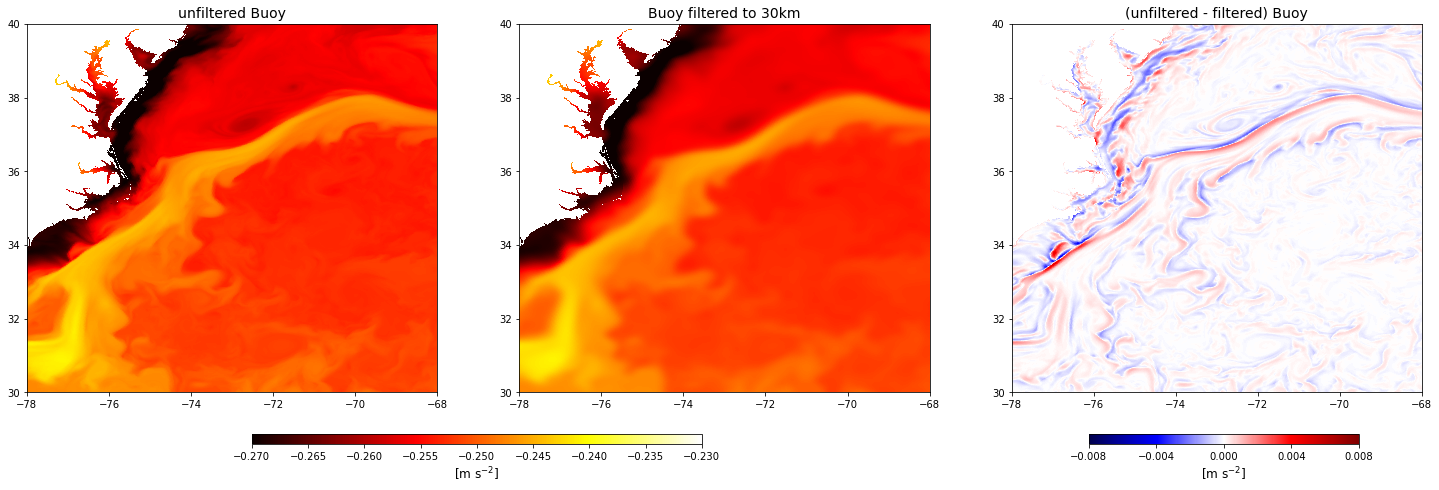

In [27]:
vmin = -.27
vmax = -.23


fig,axs = plt.subplots(1,3,figsize=(25,8))

im = axs[0].pcolormesh(gigatl01w.lon_rho.isel(eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad)),
                       gigatl01w.lat_rho.isel(eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad)),
                       (bw).isel(time=0,eta_rho=slice(pad+1,-2-pad),
                                 xi_rho=slice(pad+1,-2-pad),z_rho=5),
    vmin=vmin, vmax=vmax, 
    cmap='hot', shading='auto', rasterized=True
)
axs[0].set_title('unfiltered Buoy', fontsize=14)

axs[1].pcolormesh(gigatl01w.lon_rho.isel(eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad)),
                  gigatl01w.lat_rho.isel(eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad)),
                  (bw_filtered_to_30km).isel(time=0,eta_rho=slice(pad+1,-pad-1),
                                             xi_rho=slice(pad+1,-pad-1),z_rho=5),
    vmin=vmin, vmax=vmax, 
    cmap='hot', shading='auto', rasterized=True
)
axs[1].set_title('Buoy filtered to 30km', fontsize=14)

im2 = axs[2].pcolormesh(gigatl01w.lon_rho.isel(eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad)),
                        gigatl01w.lat_rho.isel(eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad)),
                        (bw.isel(time=0,eta_rho=slice(pad+1,-2-pad),
                                 xi_rho=slice(pad+1,-2-pad),z_rho=3)
                         - bw_filtered_to_30km.isel(time=0,eta_rho=slice(pad+1,-pad-1),xi_rho=slice(pad+1,-pad-1),z_rho=5)
                        ).isel(eta_rho=slice(None,None),xi_rho=slice(None,None)),
    vmax=.008, vmin=-.008,
    cmap='seismic', shading='auto', rasterized=True
)
axs[2].set_title('(unfiltered - filtered) Buoy', fontsize=14);

axs[0].set_xlim([-78,-68])
axs[0].set_ylim([30,40])
axs[1].set_xlim([-78,-68])
axs[1].set_ylim([30,40])
axs[2].set_xlim([-78,-68])
axs[2].set_ylim([30,40])

fig.subplots_adjust(bottom=0.24, hspace=.25)
cbaxes = fig.add_axes([0.25, 0.15, 0.25, 0.018]) 
cbar = fig.colorbar(im, orientation='horizontal', cax=cbaxes,
#                     ticks=[-2.8,-2.1,-1.4,-.7,0.,.7,1.4,2.1,2.8]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r'[m s$^{-2}$]', fontsize=12)
cbaxes = fig.add_axes([0.715, 0.15, 0.15, 0.018]) 
cbar = fig.colorbar(im2, orientation='horizontal', cax=cbaxes,
                    ticks=[-.008,-.004,0.,.004,.008]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r'[m s$^{-2}$]', fontsize=12)

plt.savefig('/home/jovyan/Figures/GIGA01_bp-30km_Feb-01.pdf')

0


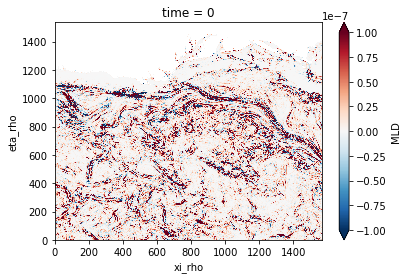

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [ ]:
wpbpw = xr.zeros_like(MLDw.isel(eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad))).load()

for i in range(len(wpbpw.time)):
    wpbpw[i] = ((((ww.isel(time=i,eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad)) 
                   - ww_filtered_to_30km.isel(time=i,eta_rho=slice(pad+1,-pad-1),xi_rho=slice(pad+1,-pad-1))
                  ) * (bw.isel(time=i,eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad))  
                       - bw_filtered_to_30km.isel(time=i,eta_rho=slice(pad+1,-pad-1),xi_rho=slice(pad+1,-pad-1))
                      )
                 ).where(xrmask.isel(eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad))!=0.)
                 * xr.DataArray(dzp1s, dims=['z_rho'])
                ).where(ww.isel(time=i,eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad)).z_rho 
                        >= MLDw.isel(time=i,eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad)) 
                       ).sum('z_rho',skipna=True) 
                / np.abs(MLDw.isel(time=i,eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad)))
               ).chunk({'eta_rho':200,'xi_rho':200})
    print(i)
    if i == 0:
        wpbpw[i].plot(vmax=1e-7)
        plt.show()
wpbpw

In [ ]:
tmp_path = f'{SCRATCH}/region01/GIGATL/'+f'wb-30km_z0-MLD_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
wpbpw.reset_coords(drop=True).chunk({'time':10}).to_dataset(name='wpbp').to_zarr(store_tmp, mode='w')

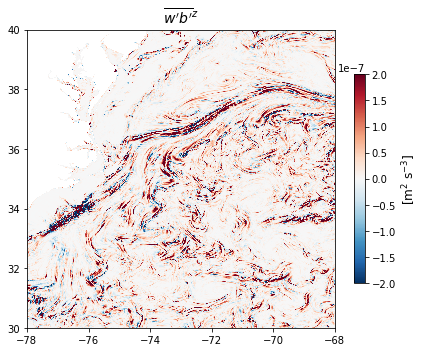

In [9]:
wpbpw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/GIGATL/wb-30km_z0-MLD_fma.zarr")).wpbp
pad = 1

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
im = ax.pcolormesh(gigatl01w.lon_rho.isel(eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad)),
                   gigatl01w.lat_rho.isel(eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad)),
                   wpbpw.isel(time=0).where(gigatl01w.mask_rho.isel(eta_rho=slice(pad+1,-2-pad),xi_rho=slice(pad+1,-2-pad))!=0.),
                   vmin=-1e-7, vmax=1e-7,
                   cmap='RdBu_r', rasterized=True, shading='auto'
)

ax.set_xlim([-78,-68])
ax.set_ylim([30,40])

ax.set_title(r"$\overline{w'b'}^z$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)

plt.savefig('/home/jovyan/Figures/GIGA01_wpbpz_Feb-01.pdf')